# Experimenting with SpecletNine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from time import time
from typing import Any, Callable, Optional

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.io.cache_io import temp_dir
from src.loggers import set_console_handler_level
from src.models.speclet_nine import (
    SpecletNine,
    SpecletNineConfiguration,
    make_speclet_nine_priors_config,
)
from src.plot.plotnine_helpers import set_gg_theme
from src.project_config import read_project_configuration

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARNING)

set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

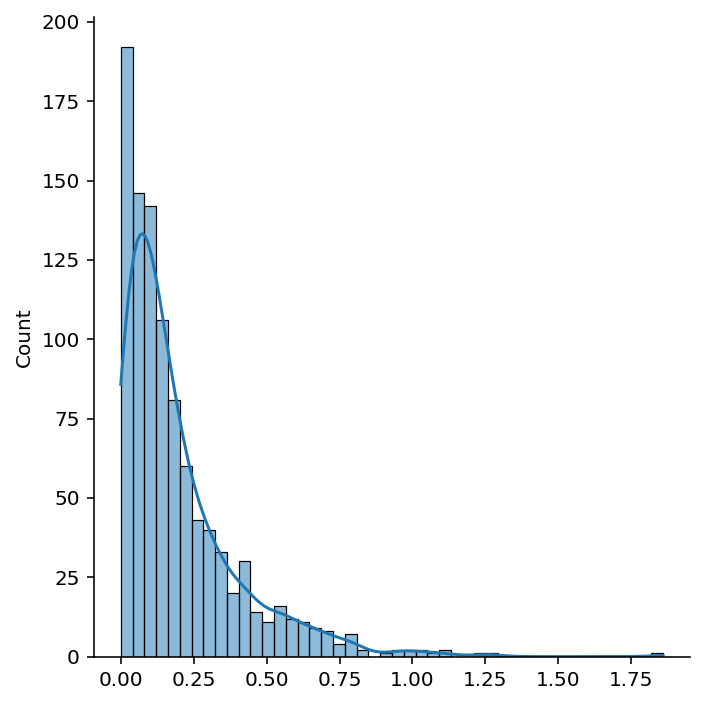

In [5]:
with pm.Model():
    x = pm.Gamma(name="x", alpha=1, beta=5).random(size=1000)

sns.displot(x=x, kind="hist", kde=True)

In [6]:
# config = make_speclet_nine_priors_config(
#     mu_mu_beta_mu=0.0,
#     mu_mu_beta_sigma=1.0,
#     sigma_mu_beta_sigma=1.0,
#     sigma_beta_alpha=1.0,
#     sigma_beta_beta=5.0,
#     alpha_alpha=2.0,
#     alpha_beta=0.3,
# )
config = SpecletNineConfiguration()
sp9 = SpecletNine("sp9-expr", root_cache_dir=temp_dir(), config=config)
# sp9 = SpecletNine("sp9-expr", root_cache_dir=temp_dir())
sp9.build_model()

[11/05/21 15:19:13] WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=637242;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

In [7]:
data = sp9.data_manager.get_data()
# ct_i = np.abs(np.random.normal(loc=100, scale=5, size=data.shape[0])) + 1
# # ct_i = np.ones(data.shape[0])
# ct_f = np.abs(ct_i + np.random.normal(loc=0, scale=10, size=data.shape[0]))
# data["counts_initial_adj"] = ct_i.astype(np.int64)
# data["counts_final"] = ct_f.astype(np.int64)
# sp9.data_manager.set_data(data, apply_transformations=False)

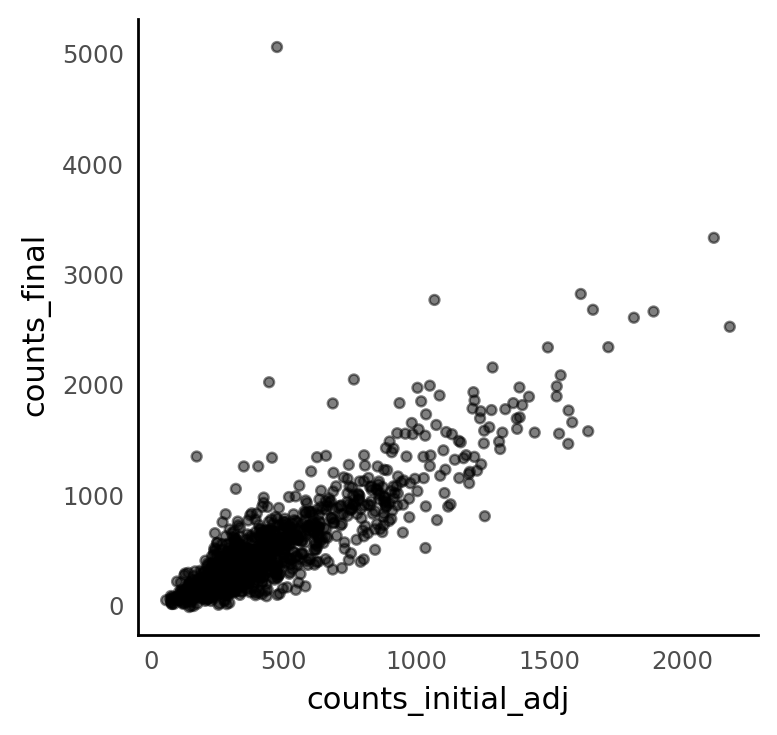

<ggplot: (352020703)>

In [8]:
(
    gg.ggplot(
        data.astype({"counts_initial_adj": float, "counts_final": float}),
        gg.aes(x="counts_initial_adj", y="counts_final"),
    )
    + gg.geom_point(alpha=0.5)
)

In [9]:
assert sp9.model is not None
with sp9.model:
    sp9_prior_pred = pm.sample_prior_predictive(random_seed=1234)

In [10]:
def plot_prior_pred(prior_samples: np.ndarray, scales: str = "fixed") -> gg.ggplot:
    """Plot prior predictive samples

    Args:
        prior_samples ([type]): Prior samples array with shape [samples, draws].

    Returns:
        gg.ggplot: A nice lil' plot for you and your buds.
    """
    prior_pred_df = (
        pd.DataFrame(prior_samples.T)
        .pivot_longer(names_to="prior_pred_sample", values_to="draw")
        .astype({"prior_pred_sample": "str"})
    )
    return (
        gg.ggplot(prior_pred_df, gg.aes(x="draw", fill="prior_pred_sample"))
        + gg.facet_wrap("prior_pred_sample", scales=scales)
        + gg.geom_histogram(bins=50, alpha=0.5, position="identity")
        + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(figure_size=(8, 6), legend_position="none")
    )

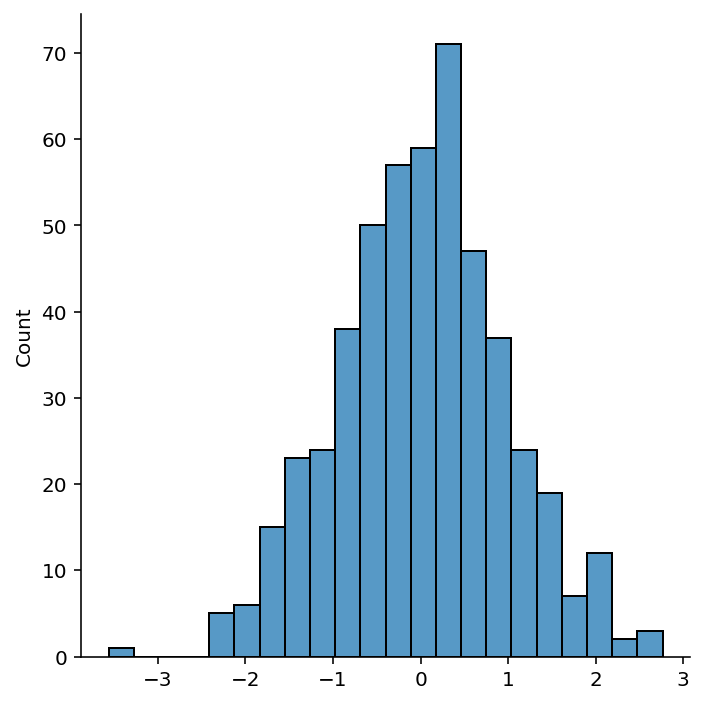

In [11]:
# plot_prior_pred(sp9_prior_pred["mu_beta"][:6, :, :].reshape(6, -1))
sns.displot(sp9_prior_pred["mu_beta"], kind="hist")
plt.show()

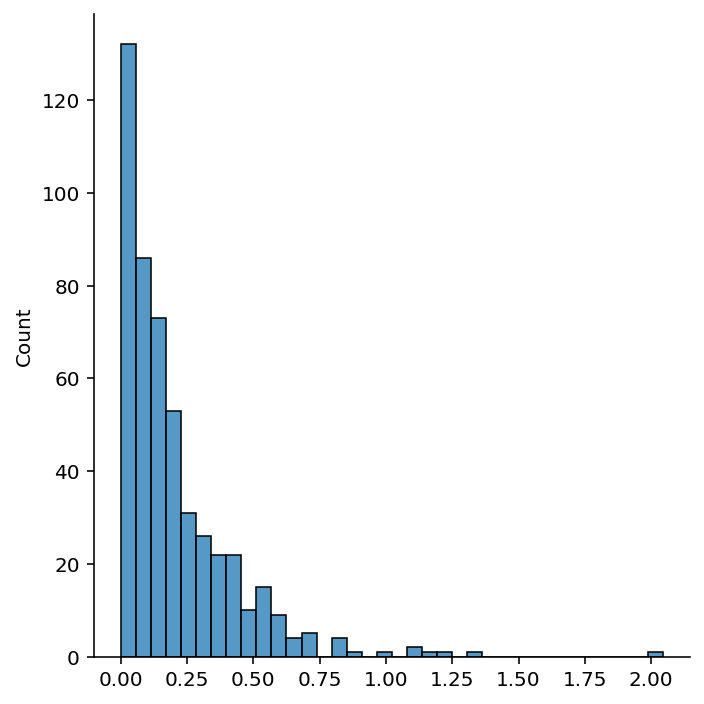

In [12]:
sns.displot(sp9_prior_pred["sigma_beta"], kind="hist")
plt.show()
# plot_prior_pred(sp9_prior_pred["sigma_beta"][:6, :, :].reshape(6, -1))

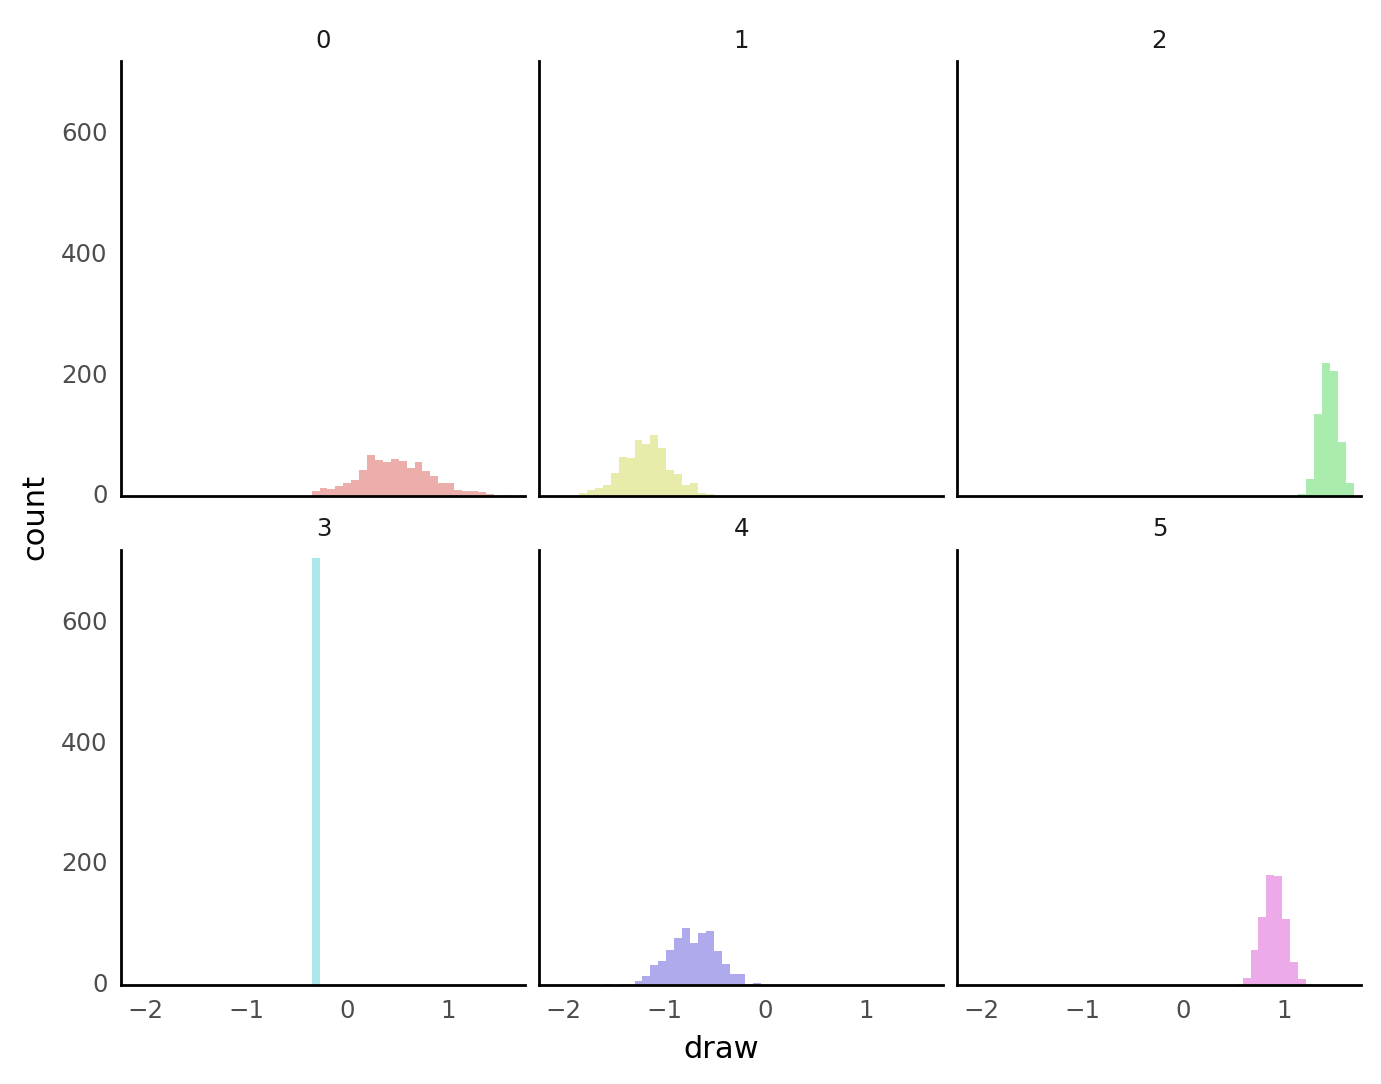

<ggplot: (360590870)>

In [13]:
plot_prior_pred(sp9_prior_pred["beta"][:6, :, :].reshape(6, -1))

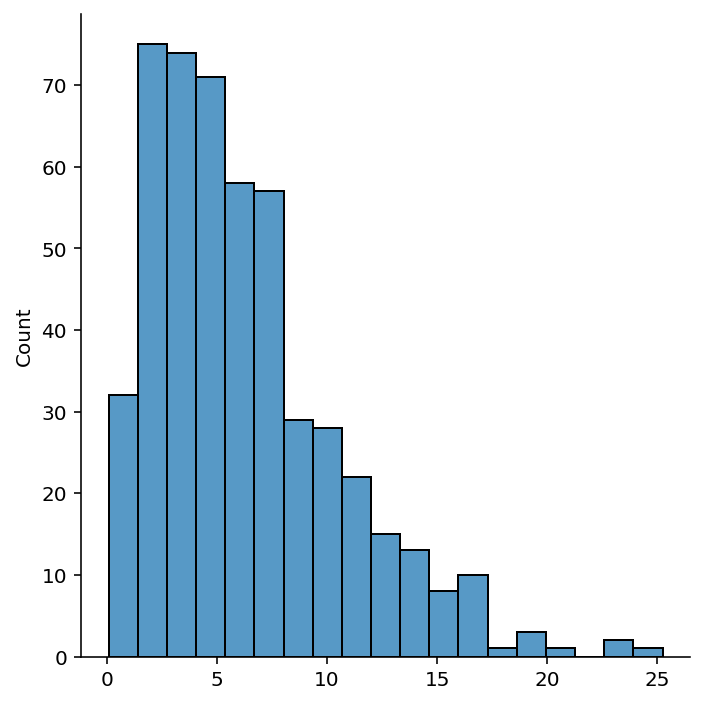

In [14]:
sns.displot(sp9_prior_pred["alpha"], kind="hist")
plt.show()

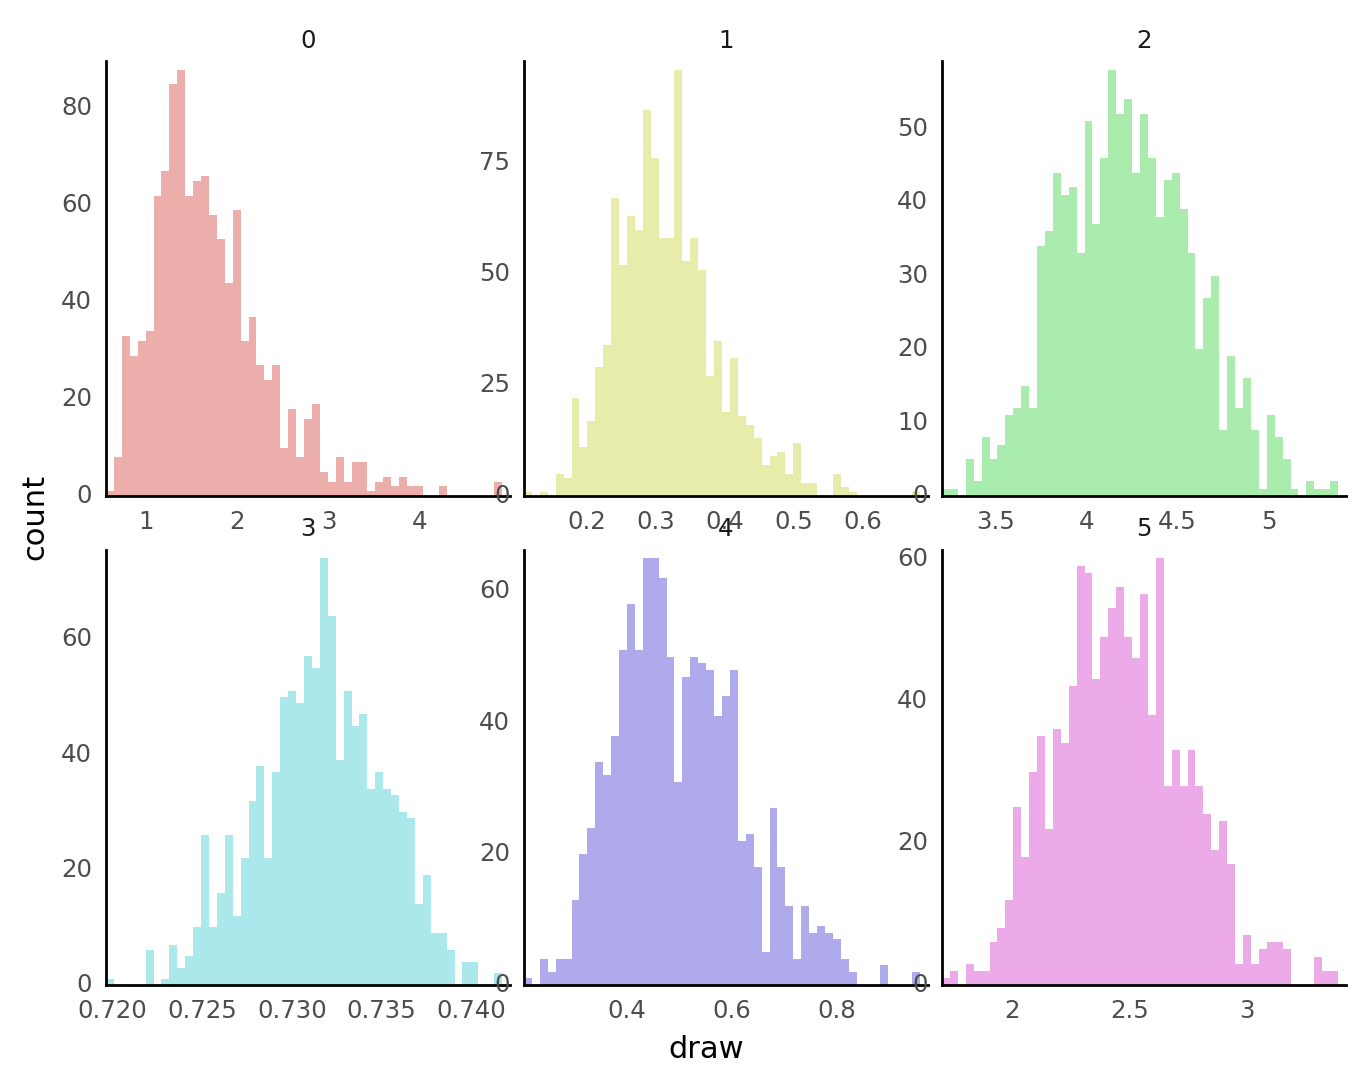

<ggplot: (360584982)>

In [15]:
plot_prior_pred(sp9_prior_pred["mu"][:6, :], scales="free")

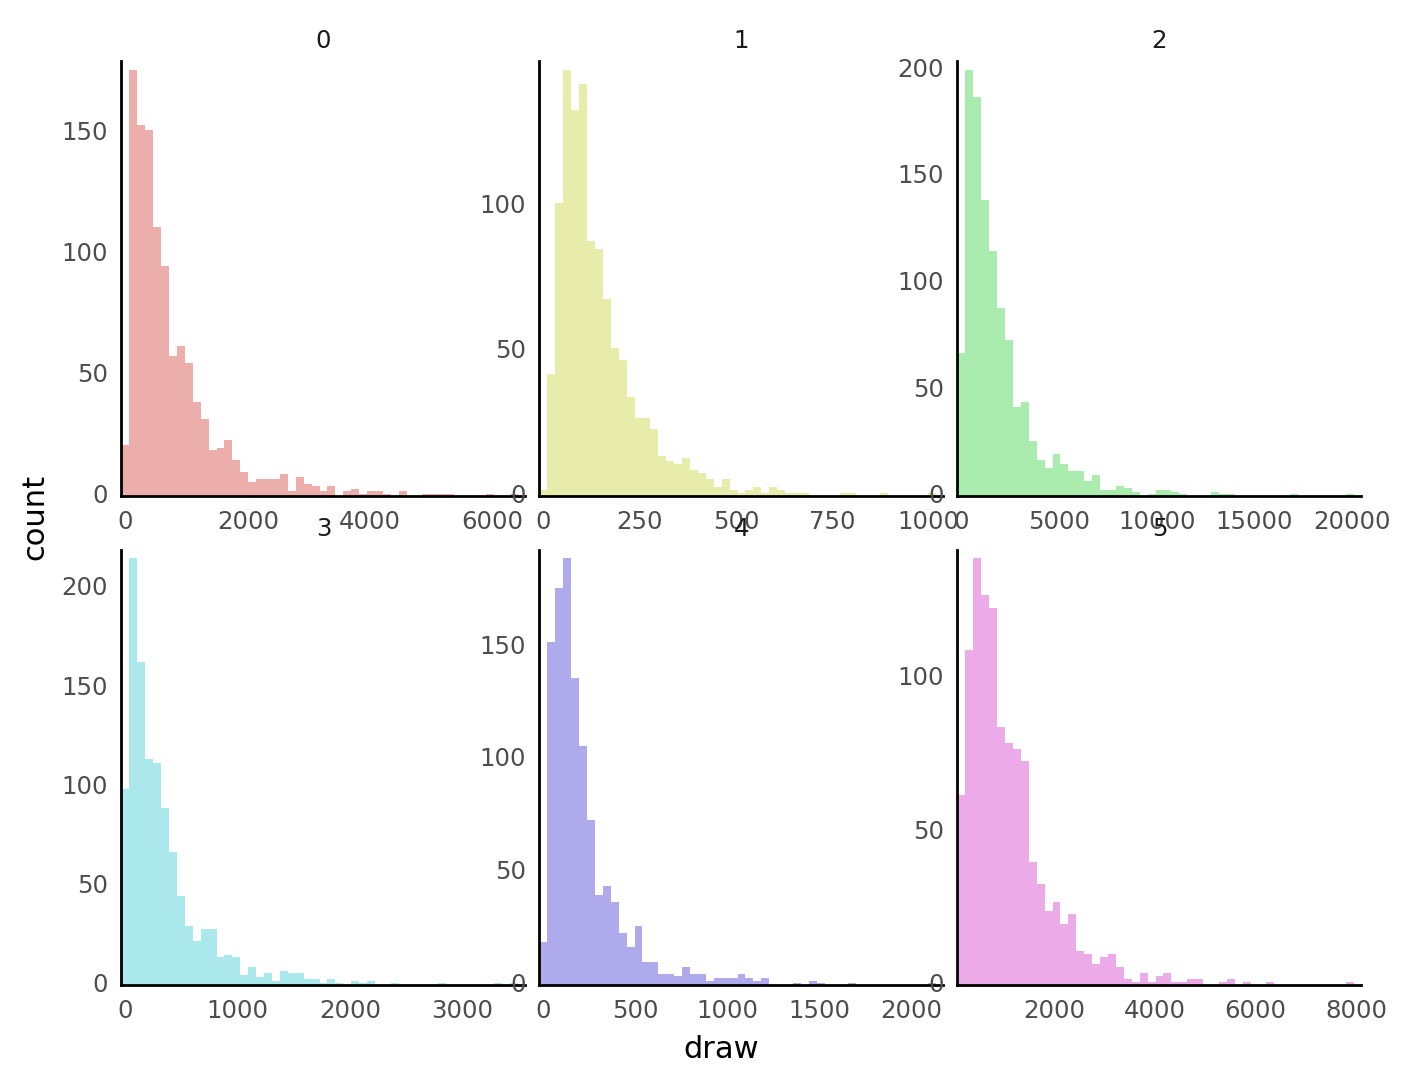

<ggplot: (360536706)>

In [16]:
(plot_prior_pred(sp9_prior_pred["y"][:6, :], scales="free"))

In [17]:
sp9_prior_pred["alpha"][:6]

array([2.95011125, 8.33274786, 1.83625035, 1.36666275, 3.05455894,
       5.08640347])

In [18]:
sp9_prior_pred["mu"].mean(axis=1)[:6]

array([1.71795409, 0.31735273, 4.22479929, 0.73161481, 0.50172579,
       2.46702875])

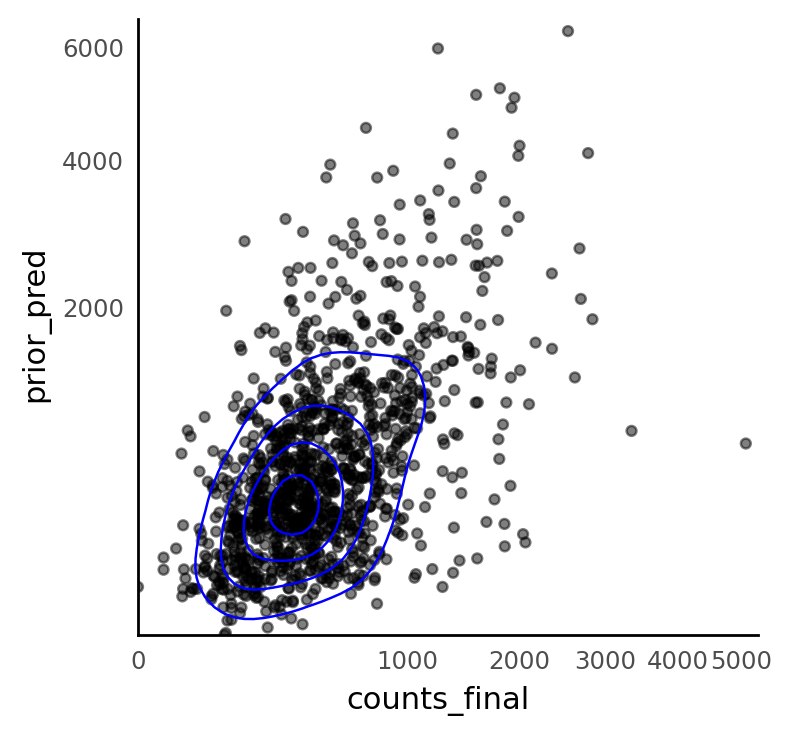

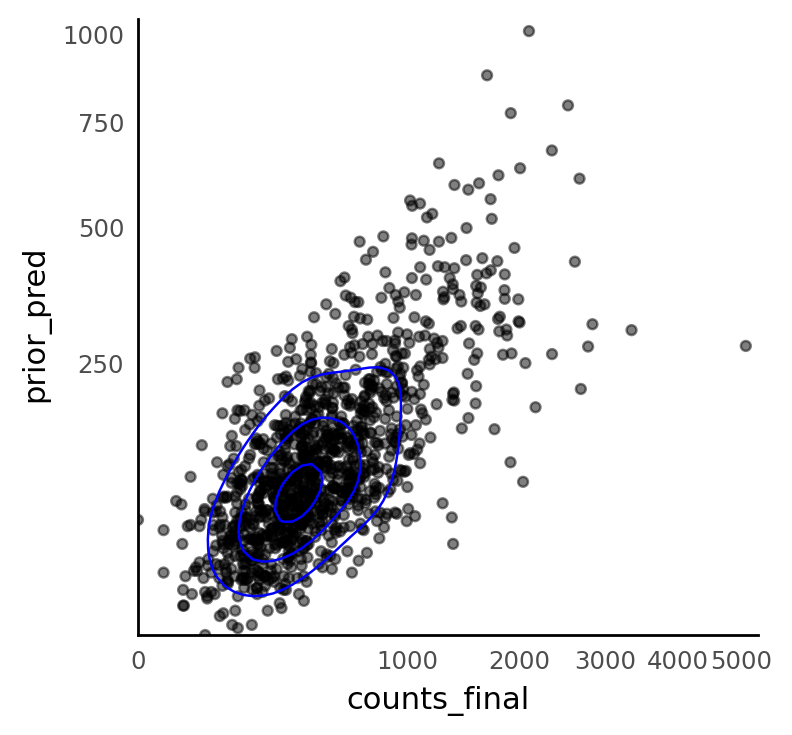

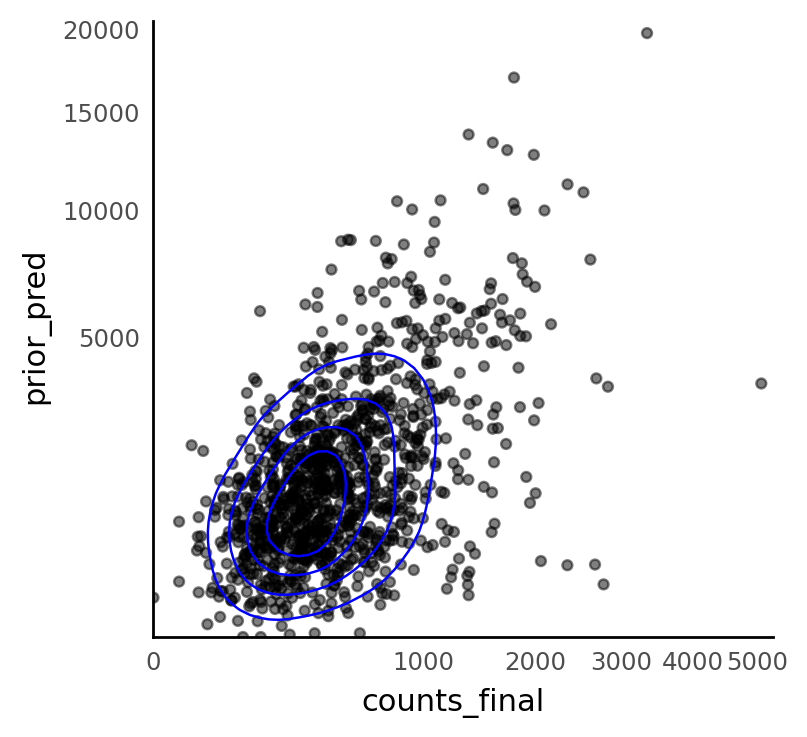

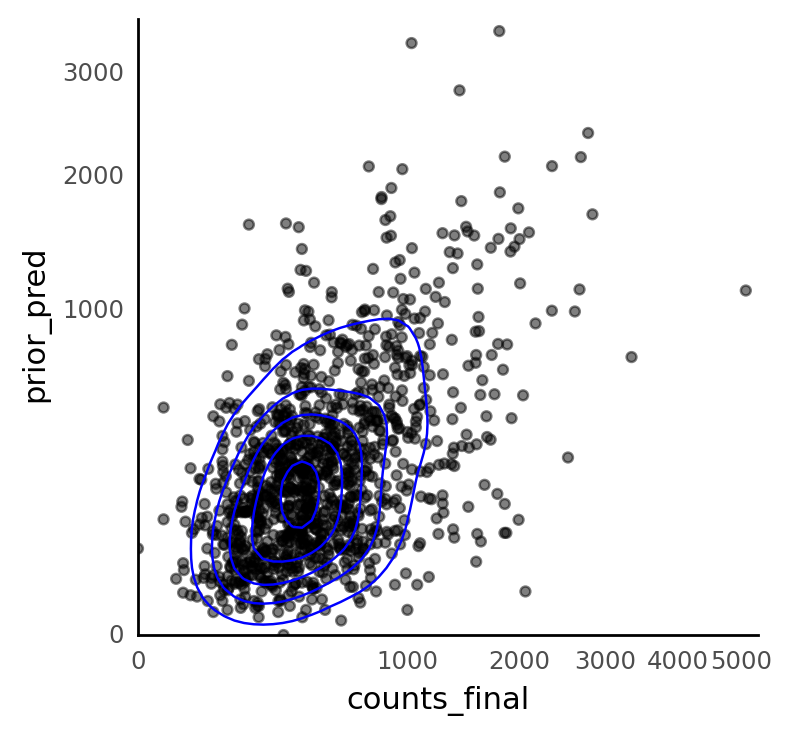

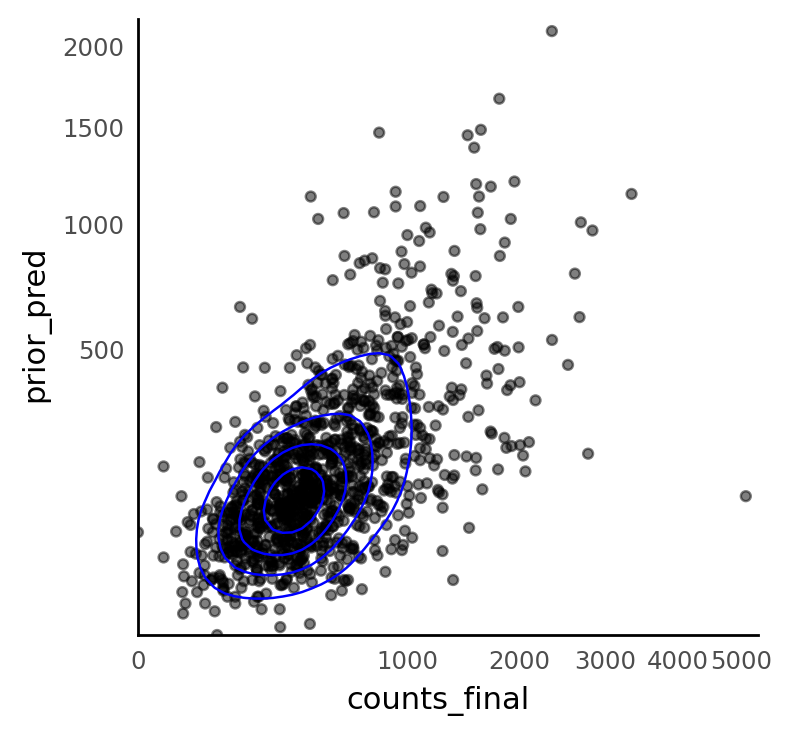

In [19]:
for i in range(5):
    y_prior_pred = (
        data.copy()
        .assign(prior_pred=sp9_prior_pred["y"][i, :])
        .astype({"counts_final": int})
    )
    print(
        gg.ggplot(y_prior_pred, gg.aes(x="counts_final", y="prior_pred"))
        + gg.geom_point(alpha=0.5)
        + gg.geom_density_2d(color="blue")
        + gg.scale_x_sqrt(expand=(0, 0, 0.02, 0))
        + gg.scale_y_sqrt(expand=(0, 0, 0.02, 0))
    )

In [20]:
def plot_prior_summary(
    prior_pred: np.ndarray, real_values: pd.Series, fxn: Callable
) -> gg.ggplot:
    prior_pred_means = fxn(prior_pred, axis=1)

    return (
        gg.ggplot(pd.DataFrame({"x": prior_pred_means}), gg.aes(x="x"))
        + gg.geom_histogram(bins=30)
        + gg.geom_vline(xintercept=fxn(real_values), color="blue")
        + gg.scale_x_log10(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    )

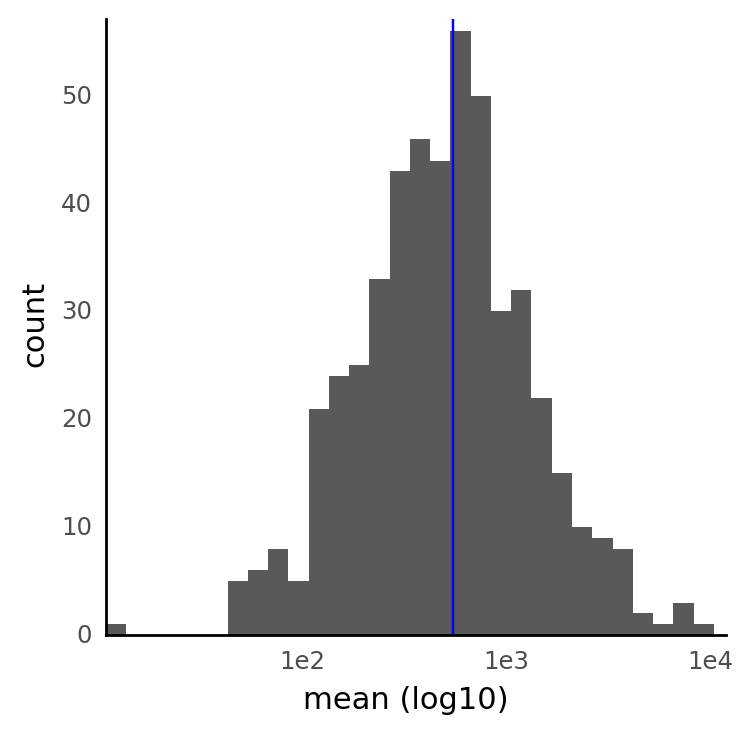

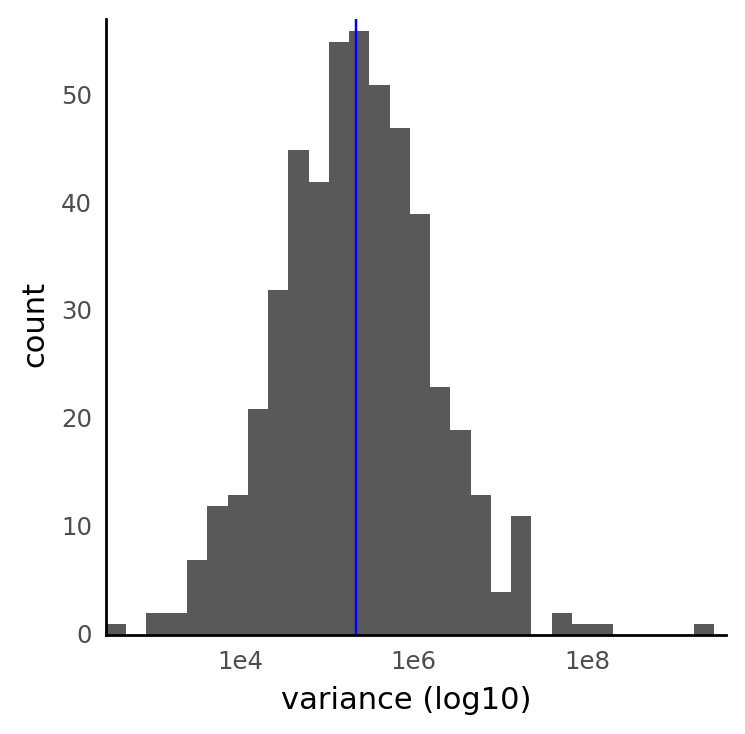

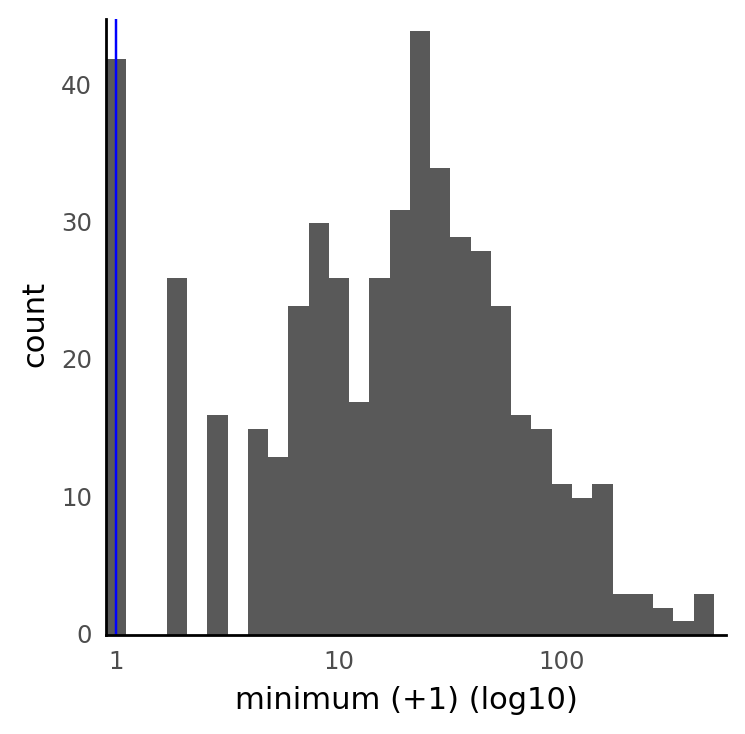

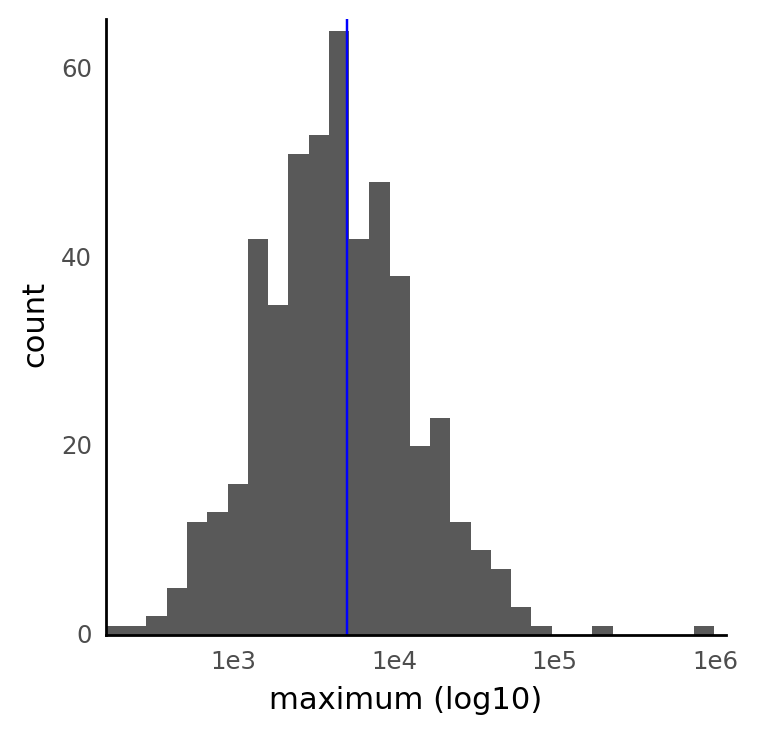

In [21]:
def min_p1(*args: Any, **kwargs: dict[str, Any]) -> Any:
    return np.min(*args, **kwargs) + 1


summary_stats: dict[str, Callable] = {
    "mean": np.mean,
    "variance": np.var,
    "minimum (+1)": min_p1,
    "maximum": np.max,
}

for name, fxn in summary_stats.items():
    p = plot_prior_summary(sp9_prior_pred["y"], data.counts_final, fxn) + gg.labs(
        x=f"{name} (log10)"
    )
    print(p)

---

In [22]:
sp9_mcmc = sp9.mcmc_sample_model(random_seed=RANDOM_SEED, ignore_cache=False)

In [23]:
sp9_var_names = [
    "mu_beta",
    "sigma_beta",
    "beta",
    "alpha",
]

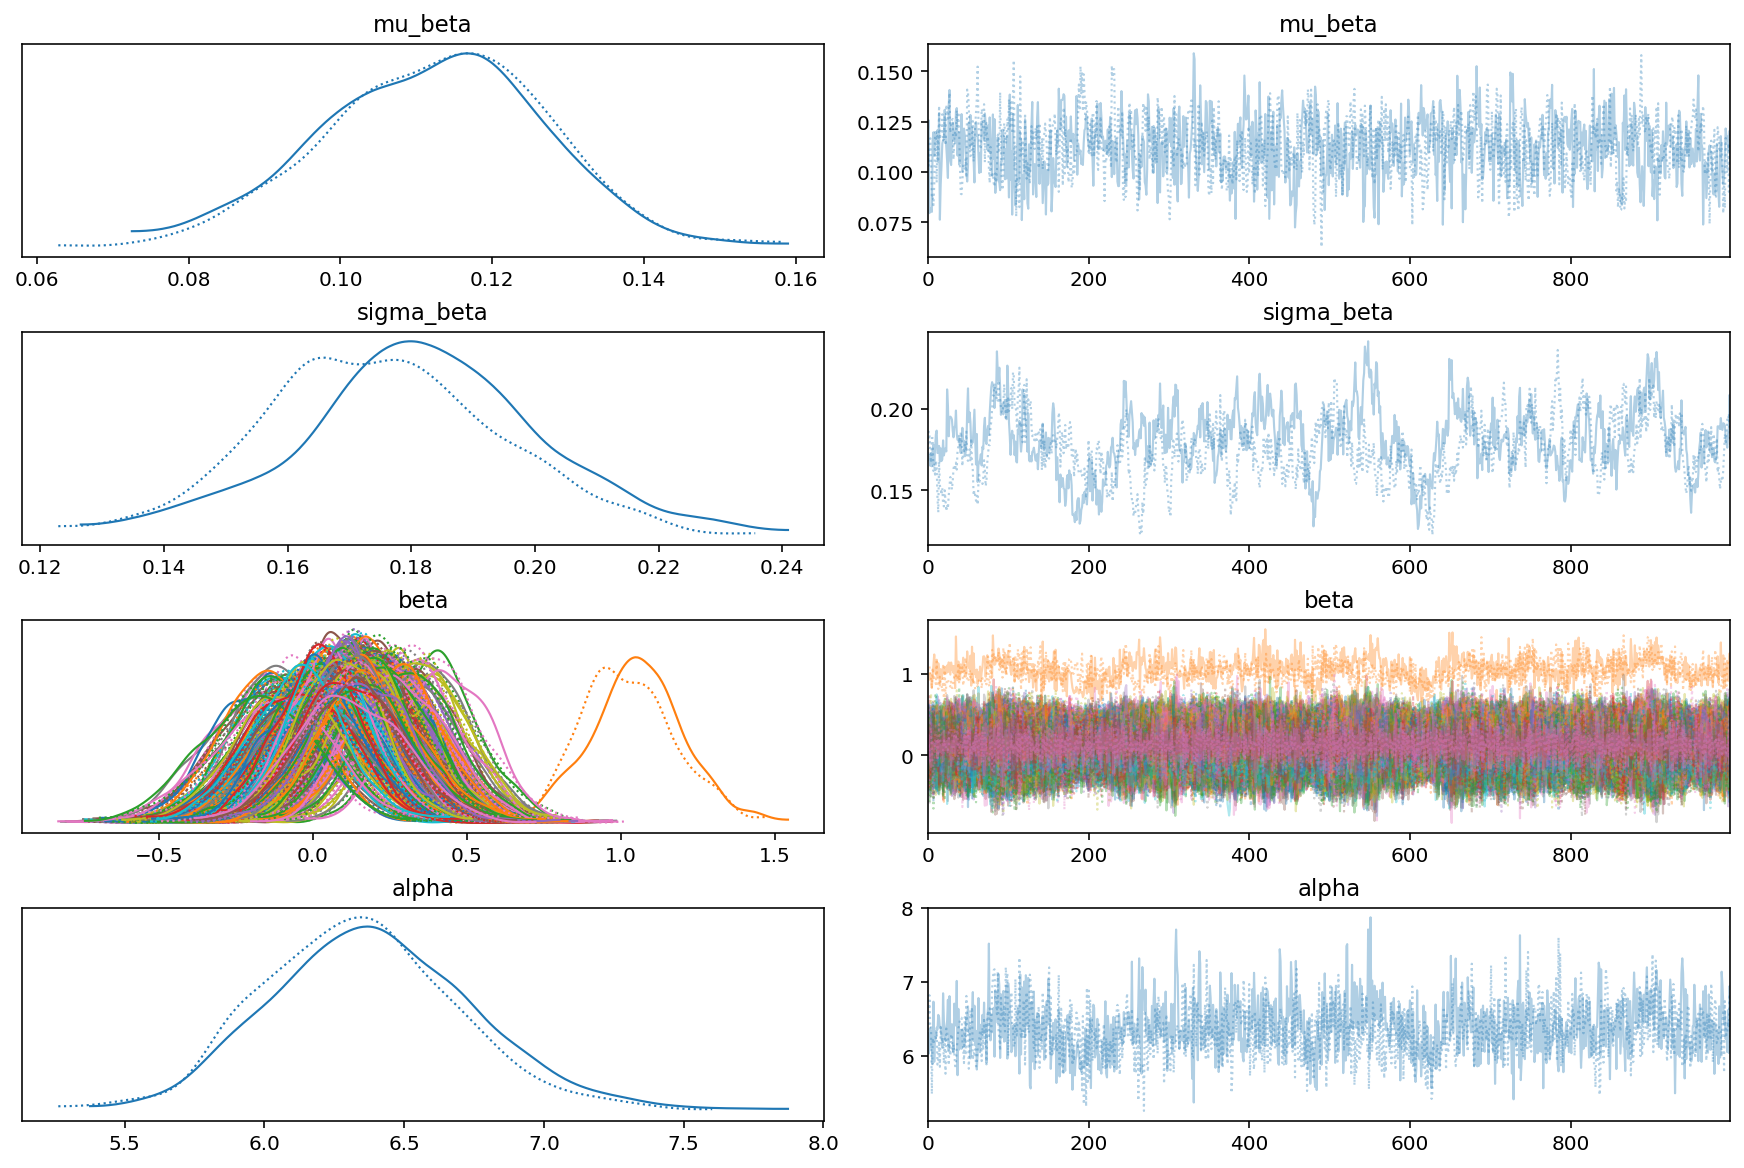

In [24]:
az.plot_trace(sp9_mcmc, var_names=sp9_var_names)
plt.show()

In [25]:
(
    az.summary(sp9_mcmc, var_names=sp9_var_names, hdi_prob=HDI_PROB)
    .sort_values("r_hat", ascending=False)
    .head()
)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
sigma_beta  0.178  0.019     0.147      0.209      0.002    0.002      71.0   
beta[34,3]  0.155  0.151    -0.077      0.406      0.003    0.003    3591.0   
beta[43,3]  0.128  0.139    -0.096      0.346      0.002    0.003    3675.0   
beta[11,2]  0.125  0.166    -0.125      0.406      0.003    0.003    3163.0   
beta[81,6]  0.169  0.146    -0.064      0.396      0.002    0.002    4641.0   

            ess_tail  r_hat  
sigma_beta     185.0   1.03  
beta[34,3]     923.0   1.01  
beta[43,3]    1449.0   1.01  
beta[11,2]    1247.0   1.01  
beta[81,6]    1494.0   1.01

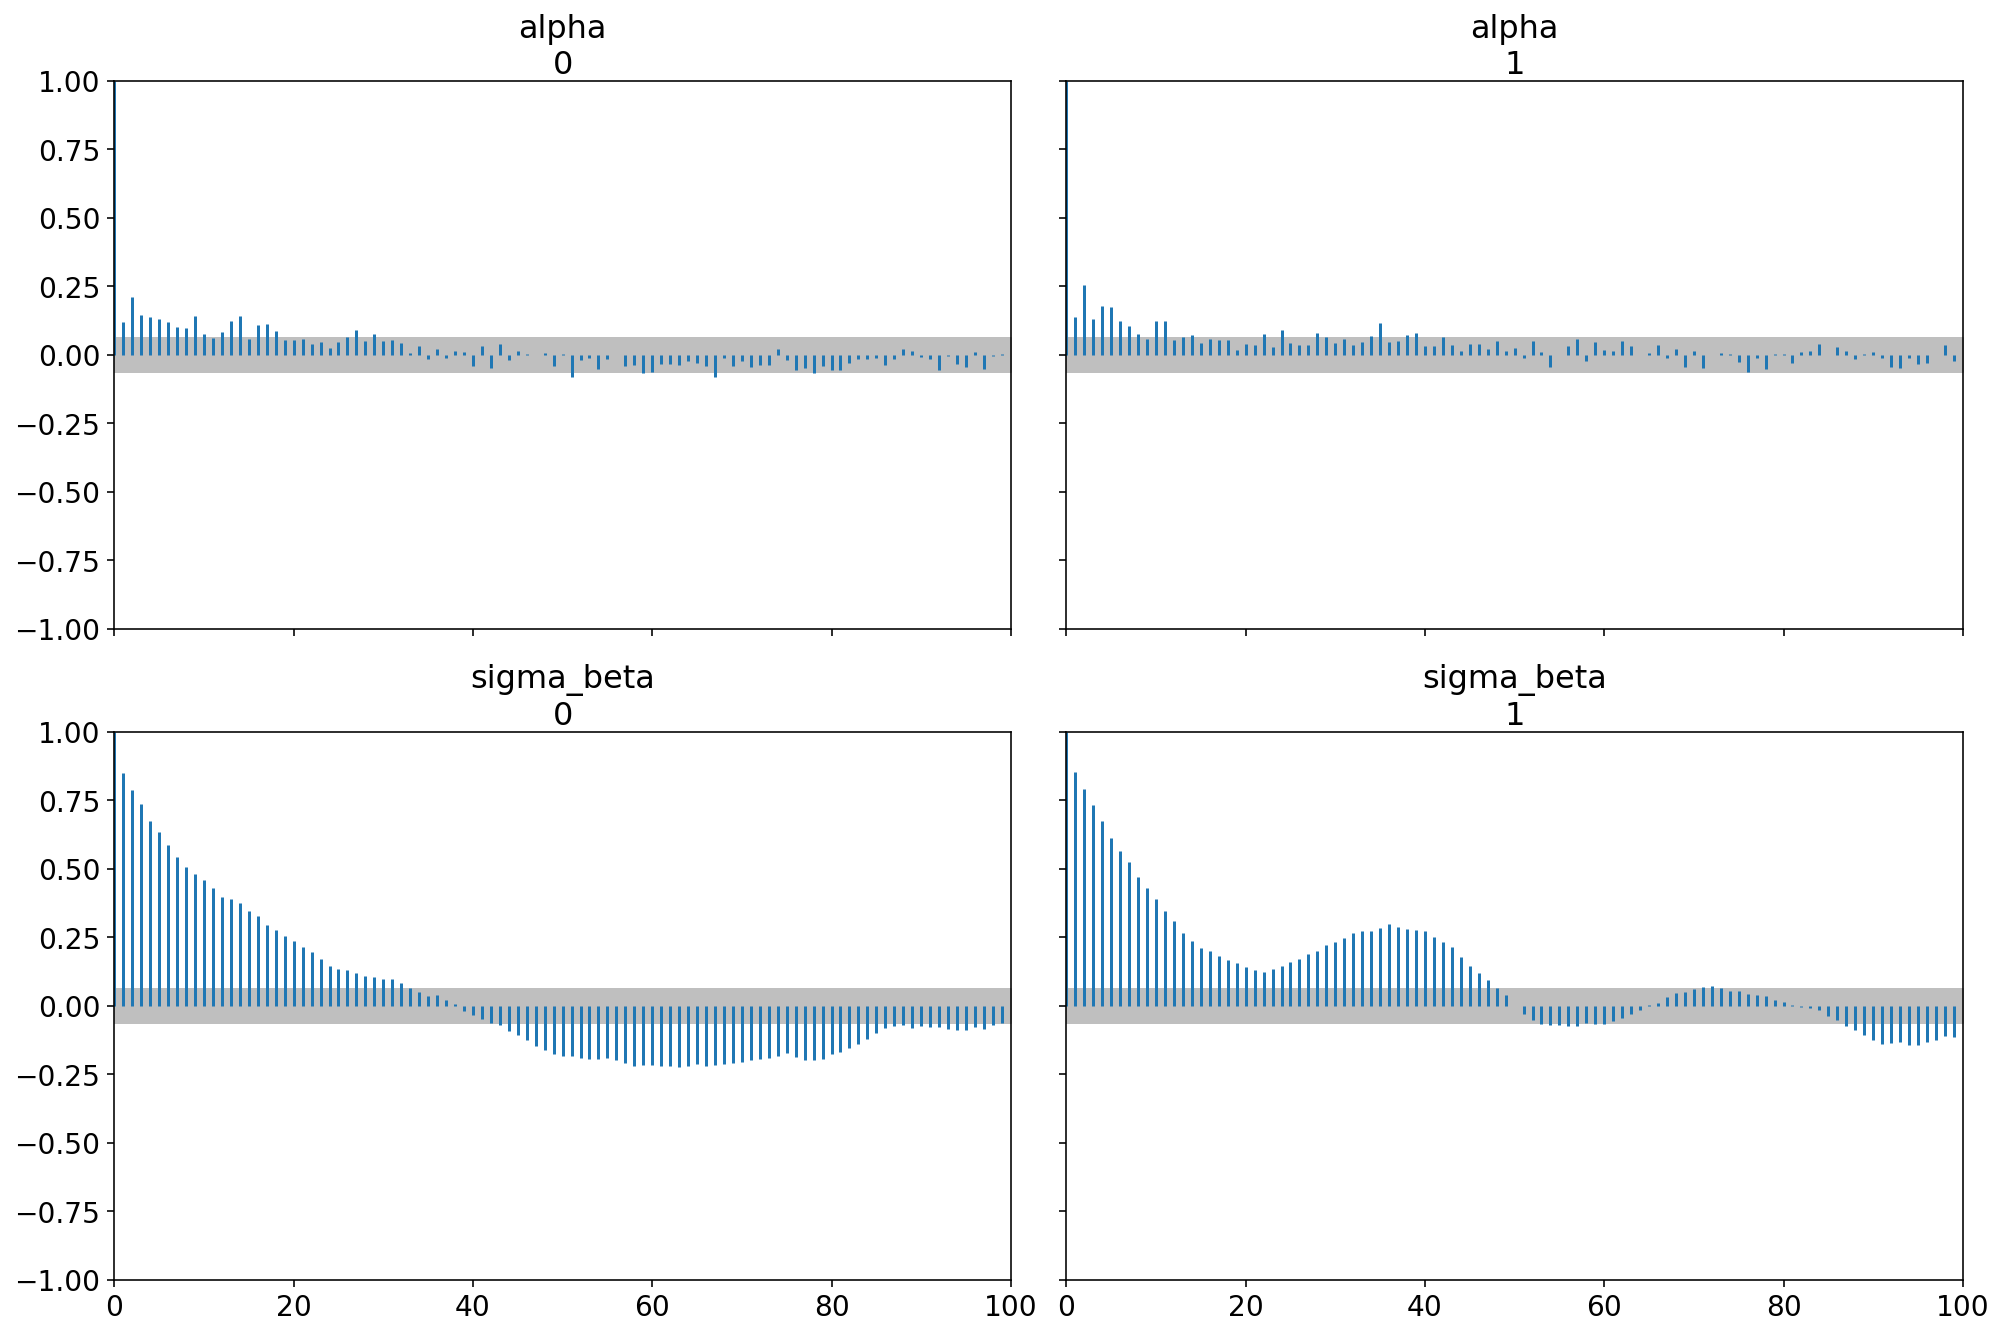

In [26]:
az.plot_autocorr(sp9_mcmc, var_names=["alpha", "sigma_beta"], grid=(2, 2))
plt.show()

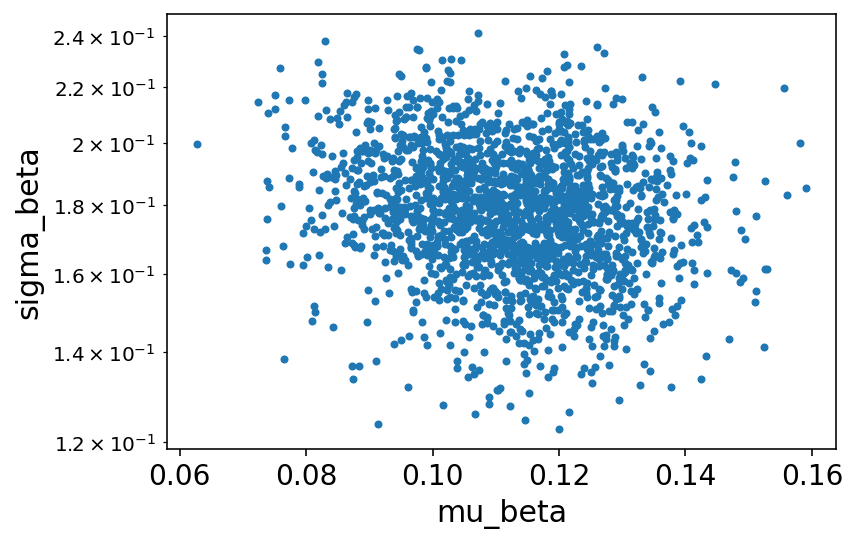

In [27]:
ax = az.plot_pair(sp9_mcmc, var_names=["mu_beta", "sigma_beta"], divergences=True)
ax.set_yscale("log")
plt.show()

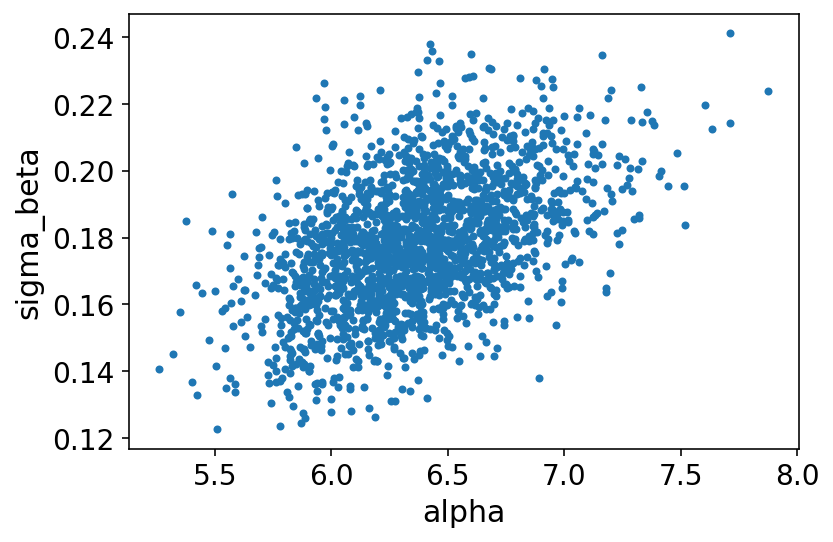

In [28]:
ax = az.plot_pair(sp9_mcmc, var_names=["alpha", "sigma_beta"], divergences=True)
# ax.set_yscale("log")
plt.show()

In [29]:
def scale_pair_plot_yaxis(axes: np.ndarray) -> None:
    for ax in axes.flatten():
        ax.set_yscale("log")
    return None

In [30]:
data.hugo_symbol.cat.categories[34], data.depmap_id.cat.categories[3]

('DMTN', 'ACH-001526')

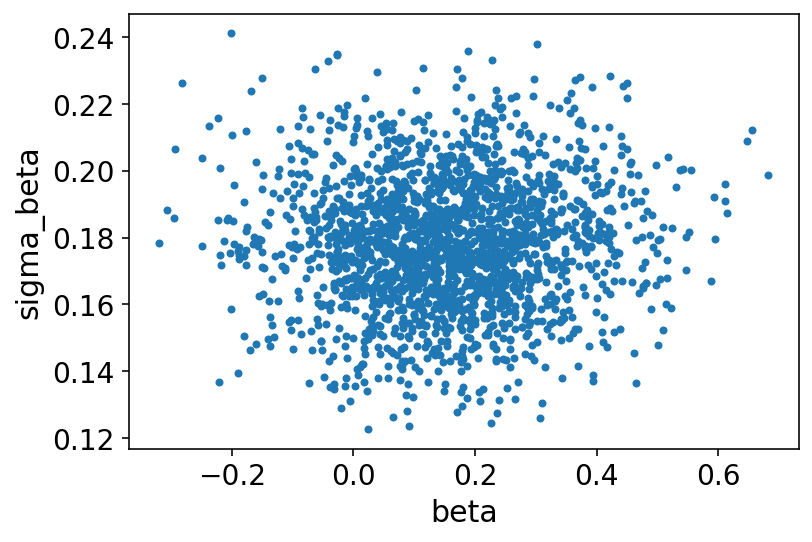

In [31]:
axes = az.plot_pair(
    sp9_mcmc,
    var_names=["beta", "sigma_beta"],
    coords={"gene": "BRAF", "cell_line": "ACH-001957"},
    divergences=True,
)
ax.set_yscale("log")
plt.show()

In [32]:
from src.analysis import pymc3_analysis as pmanal

In [33]:
beta_post = (
    az.summary(sp9_mcmc, var_names="beta", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "model_param"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="model_param",
        idx1=data.hugo_symbol.cat.categories,
        idx2=data.depmap_id.cat.categories,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)
beta_post.head()

model_param   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0   beta[0,0]  0.126  0.165    -0.155      0.373      0.003    0.003   
1   beta[0,1]  0.181  0.158    -0.045      0.459      0.003    0.003   
2   beta[0,2]  0.124  0.163    -0.138      0.387      0.003    0.003   
3   beta[0,3]  0.200  0.159    -0.058      0.447      0.003    0.003   
4   beta[0,4]  0.126  0.161    -0.121      0.400      0.003    0.003   

   ess_bulk  ess_tail  r_hat hugo_symbol   depmap_id  
0    3538.0    1397.0    1.0       SAMD8  ACH-000087  
1    2970.0    1411.0    1.0       SAMD8  ACH-001283  
2    3961.0    1315.0    1.0       SAMD8  ACH-000007  
3    2846.0    1296.0    1.0       SAMD8  ACH-001526  
4    3533.0    1330.0    1.0       SAMD8  ACH-000249

In [34]:
mu_beta_post = az.summary(sp9_mcmc, var_names="mu_beta", hdi_prob=HDI_PROB)

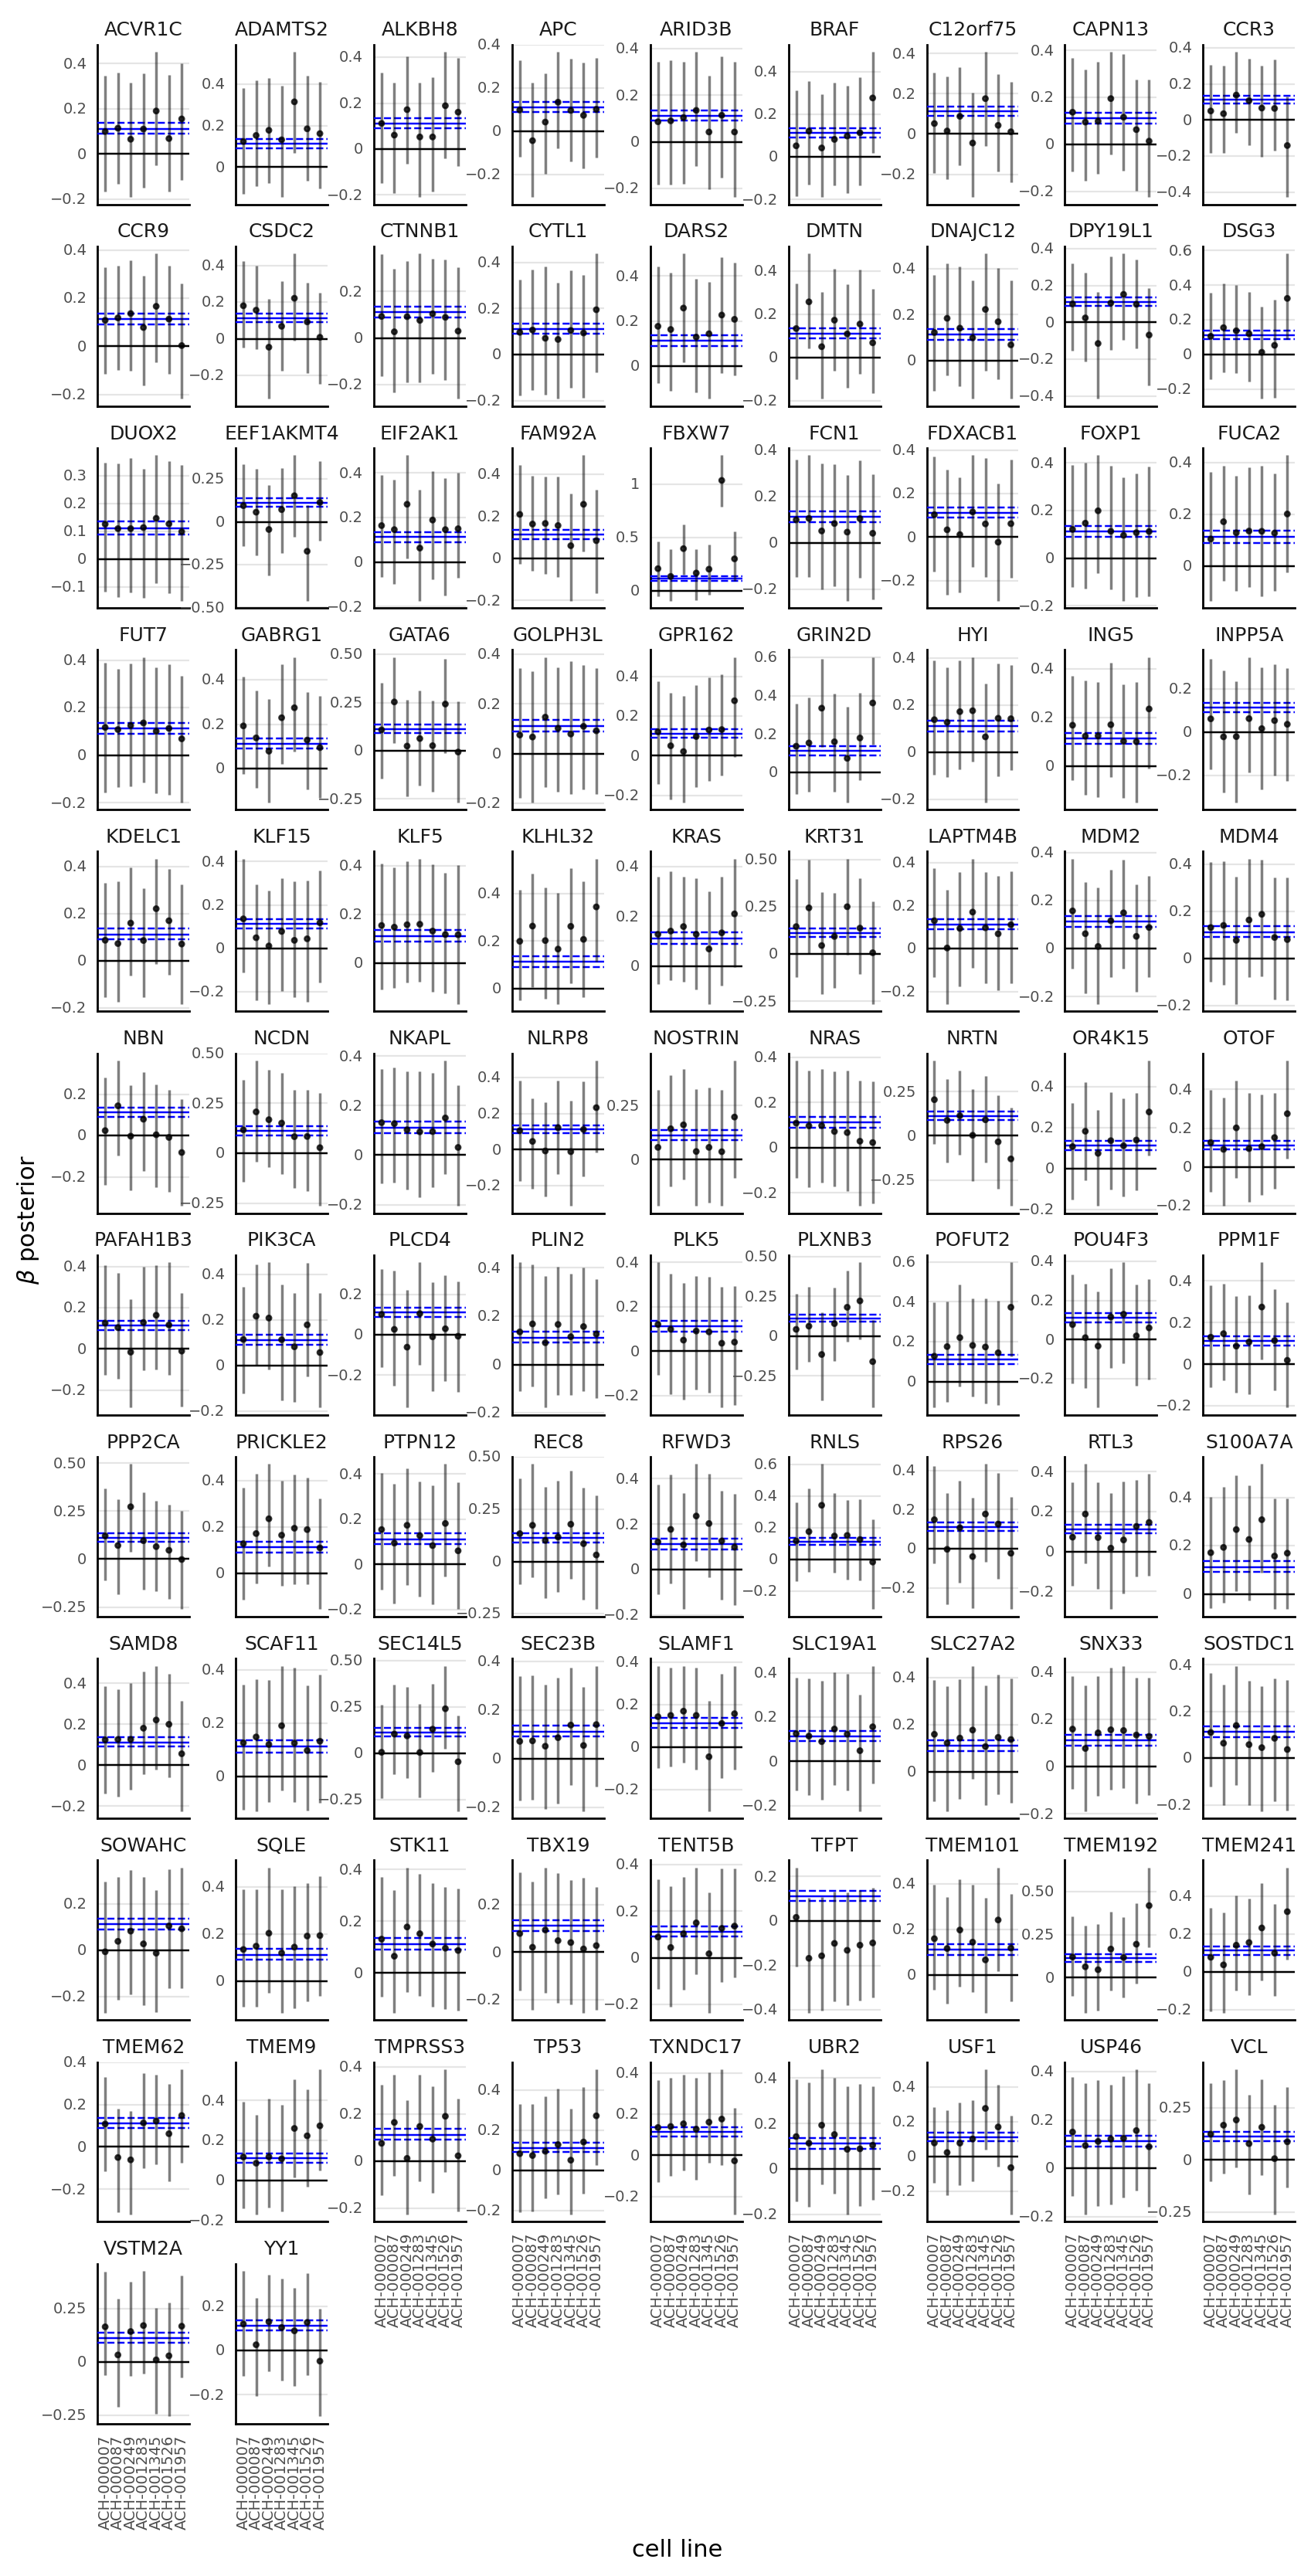

<ggplot: (364289299)>

In [35]:
(
    gg.ggplot(beta_post, gg.aes(x="depmap_id", y="mean"))
    + gg.facet_wrap("hugo_symbol", ncol=9, scales="free_y")
    + gg.geom_hline(yintercept=0, data=mu_beta_post, color="black", inherit_aes=False)
    + gg.geom_hline(
        gg.aes(yintercept="mean"), data=mu_beta_post, color="blue", inherit_aes=False
    )
    + gg.geom_hline(
        gg.aes(yintercept="hdi_5.5%"),
        data=mu_beta_post,
        color="blue",
        linetype="--",
        inherit_aes=False,
    )
    + gg.geom_hline(
        gg.aes(yintercept="hdi_94.5%"),
        data=mu_beta_post,
        color="blue",
        linetype="--",
        inherit_aes=False,
    )
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.7, alpha=0.5)
    + gg.geom_point(size=0.8, alpha=0.75)
    + gg.theme(
        figure_size=(10, 20),
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_text_y=gg.element_text(size=7),
        panel_grid_major_y=gg.element_line(),
        panel_spacing_x=0.3,
        strip_text=gg.element_text(size=9),
    )
    + gg.labs(x="cell line", y="$\\beta$ posterior")
)

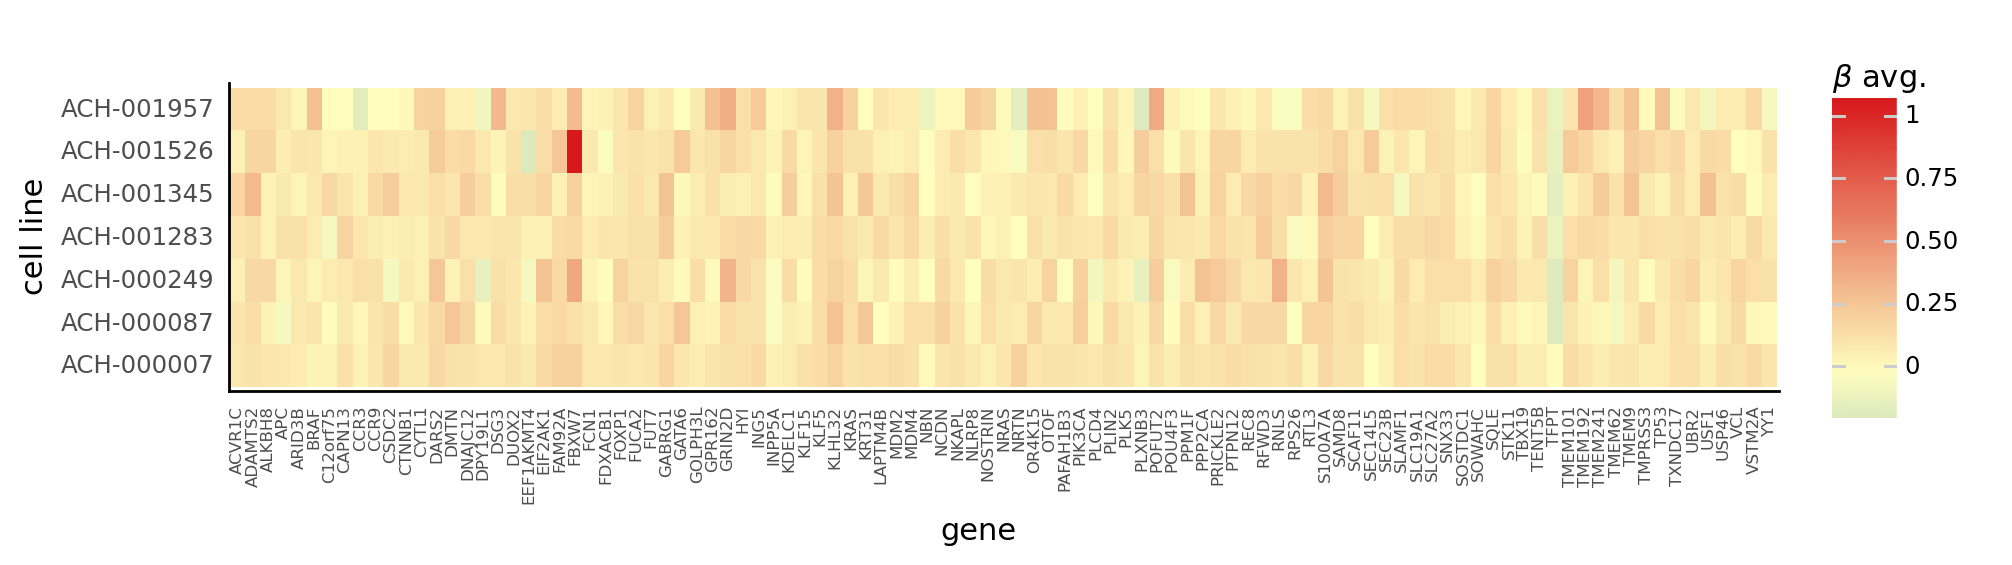

<ggplot: (361646647)>

In [36]:
(
    gg.ggplot(beta_post, gg.aes(x="hugo_symbol", y="depmap_id", fill="mean"))
    + gg.geom_tile()
    + gg.scale_fill_gradient2(high="#d7191c", low="#2c7bb6", mid="#ffffbf", middle=0)
    + gg.theme(axis_text_x=gg.element_text(size=6, angle=90), figure_size=(10, 2))
    + gg.labs(x="gene", y="cell line", fill="$\\beta$ avg.")
)

<AxesSubplot:xlabel='y'>

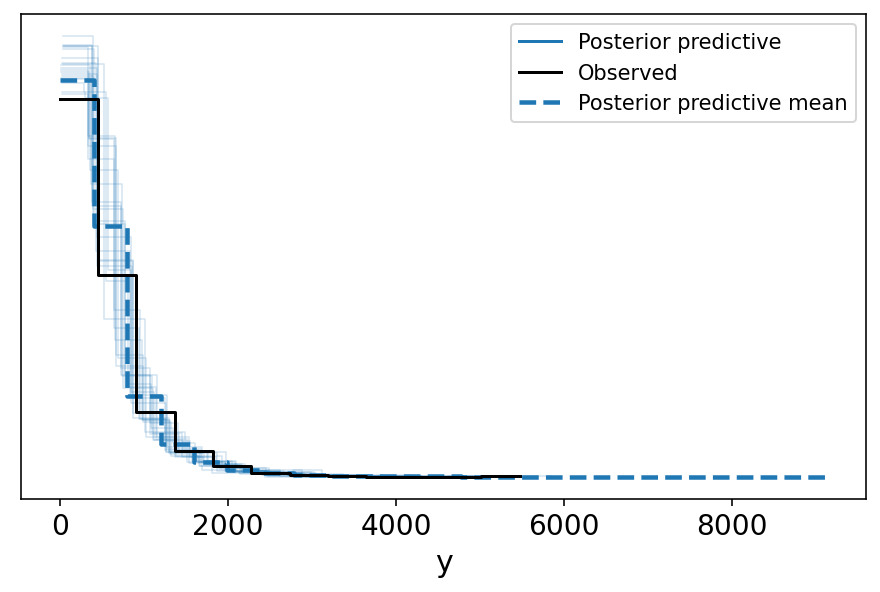

In [37]:
az.plot_ppc(sp9_mcmc, num_pp_samples=20, random_seed=1234)

In [38]:
sp9_ppc = sp9_mcmc.posterior_predictive["y"].values.squeeze()
post_pred_data = data.copy().assign(post_pred=sp9_ppc.mean(axis=0))

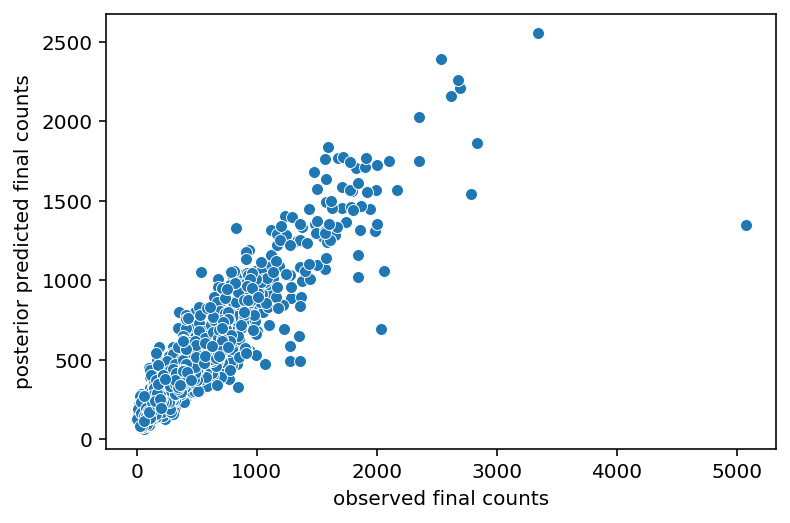

In [39]:
ax = sns.scatterplot(data=post_pred_data, x="counts_final", y="post_pred")
ax.set_xlabel("observed final counts")
ax.set_ylabel("posterior predicted final counts")
plt.show()

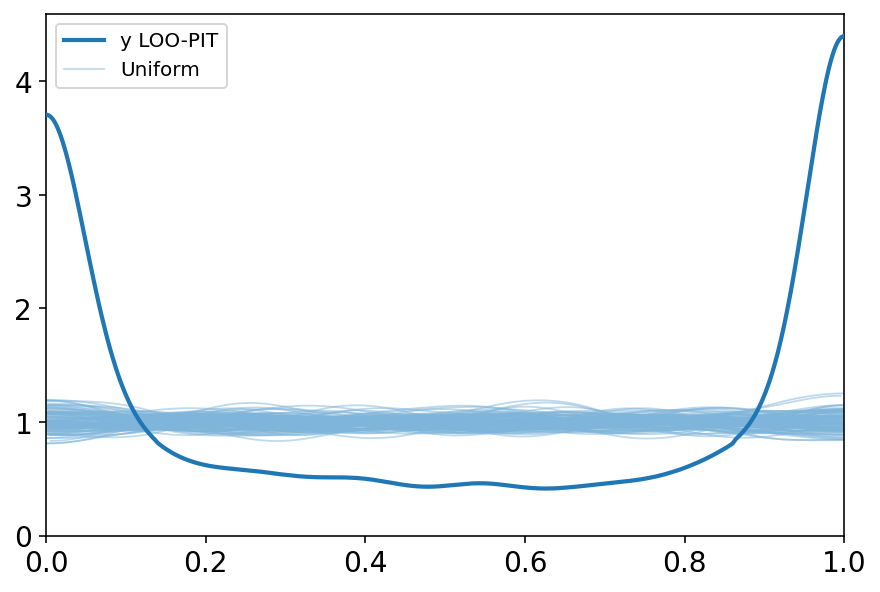

In [40]:
az.plot_loo_pit(sp9_mcmc, y="y")
plt.show()

In [41]:
sp9_loo_pit = az.loo_pit(sp9_mcmc, y="y")

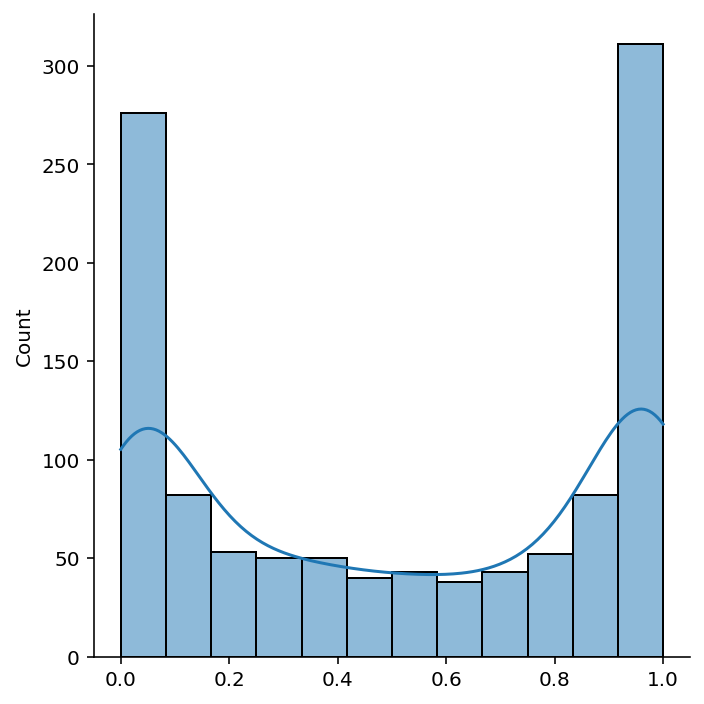

In [42]:
sns.displot(sp9_loo_pit, kind="hist", kde=True)
plt.show()

In [43]:
sp9_loo = az.loo(sp9_mcmc, pointwise=True, var_name="y")

In [44]:
post_pred_data["loo"] = sp9_loo.loo
post_pred_data["pareto_k"] = sp9_loo.pareto_k

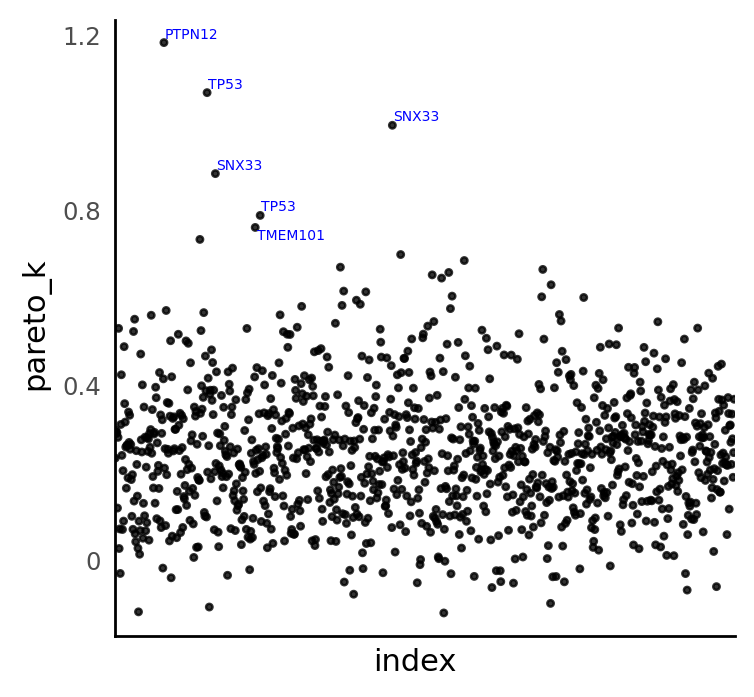

<ggplot: (363400909)>

In [45]:
(
    gg.ggplot(post_pred_data.reset_index(), gg.aes(x="index", y="pareto_k"))
    + gg.geom_point(size=0.8, alpha=0.8)
    + gg.geom_text(
        gg.aes(label="hugo_symbol"),
        post_pred_data.reset_index().query("pareto_k > 0.75"),
        color="blue",
        size=5,
        adjust_text={"color": "blue"},
    )
    + gg.scale_x_continuous(expand=(0, 1))
    + gg.scale_y_continuous(expand=(0.04, 0))
    + gg.theme(axis_text_x=gg.element_blank())
)

---

In [46]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.68 minutes


In [47]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-11-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: sp9

pandas    : 1.3.2
janitor   : 0.21.0
seaborn   : 0.11.2
logging   : 0.5.1.2
matplotlib: 3.4.3
arviz     : 0.11.2
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
pymc3     : 3.11.2
plotnine  : 0.8.0
numpy     : 1.21.2

